In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data = genfromtxt('small_file_correct_coord.txt', delimiter=',')
#data = genfromtxt('test_output_false_negative.txt', delimiter=',')
#data = genfromtxt('small_file.txt', delimiter=',')
data[:,4] =(data[:,4]-np.min(data[:,4]))/(np.max(data[:,4])-np.min(data[:,4]))
print(data)

[[ 0.          1.128016    0.913283   -2.69977     0.27121927]
 [ 1.          0.952915    0.519144    0.878809    0.95261156]
 [ 1.          0.434082    0.56767    -2.311936    0.93668561]
 [ 2.          2.209619    1.105468    2.333682    0.52416023]
 [ 3.          1.71197     1.189179    1.119164    0.78435412]
 [ 3.          0.461599    0.777167   -0.144536    0.75403444]
 [ 4.          2.029792    1.287946    1.30295     0.        ]
 [ 5.          0.756178    1.33176    -2.309371    0.68407621]
 [ 6.          2.1872      0.476108    2.85122     0.8842718 ]
 [ 7.          1.921325    1.287711   -2.407052    1.        ]
 [ 7.          0.24677     0.972258    1.512456    0.95922116]
 [ 8.          2.12424     1.190137    0.532672    0.63181968]
 [ 9.          2.165567    0.780356    1.333373    0.52338727]
 [10.          1.927867    0.979187   -1.390222    0.83159162]
 [10.          0.155214    1.058012   -2.217043    0.81032574]
 [11.          2.17151     0.581699   -0.050691    0.75

### reshape data

In [3]:
#print(np.min(data,axis=0)[0])
ll = []
true_vals = []
print(int(np.max(data,axis=0)[0]))
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    #print("This is mask:")
    #print(mask)
    evt = data[mask]
    #print(evt)
    #print(evt.shape[0])
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    for i, (idx1, idx2) in enumerate(pair_indices):
        l = []
        l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
        ll.append(l)
        if (evt[idx1,0] == evt[idx2,0]):
            true_vals.append(1)
        else:
            true_vals.append(0)
#print(ll)
input_data = torch.FloatTensor(ll)
input_data = torch.squeeze(input_data)
input_data.shape
truth_class = torch.FloatTensor(true_vals)
print(input_data.shape)
print(truth_class.shape)

29
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (1, 2)]
torch.Size([57, 8])
torch.Size([57])


/home/tobiasjenegger/jupy/jup_notebook/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


### simple model

In [4]:
class feed_forward_model(nn.Module):
        def __init__(self,nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                #self.another_linear = torch.nn.Linear(100,100)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor


## final training

In [5]:
print(input_data.shape)
n_epochs = 1000
model = feed_forward_model(100)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.SGD(model.parameters(), lr=9e-4)
model.train()
loss_val = []
for epoch in range(n_epochs):
    y_pred = model(input_data)
    y_true = truth_class
    loss = loss_fn(y_pred,y_true)
    loss_val.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")

torch.Size([57, 8])
Finished epoch 0, latest loss 0.7095118761062622
Finished epoch 1, latest loss 0.7072280049324036
Finished epoch 2, latest loss 0.7049645781517029
Finished epoch 3, latest loss 0.7027214169502258
Finished epoch 4, latest loss 0.7004983425140381
Finished epoch 5, latest loss 0.6982951164245605
Finished epoch 6, latest loss 0.6961116194725037
Finished epoch 7, latest loss 0.6939475536346436
Finished epoch 8, latest loss 0.6918027400970459
Finished epoch 9, latest loss 0.6896770596504211
Finished epoch 10, latest loss 0.6875703930854797
Finished epoch 11, latest loss 0.6854822635650635
Finished epoch 12, latest loss 0.6834129095077515
Finished epoch 13, latest loss 0.6813619136810303
Finished epoch 14, latest loss 0.6793289184570312
Finished epoch 15, latest loss 0.677314043045044
Finished epoch 16, latest loss 0.6753169298171997
Finished epoch 17, latest loss 0.673337459564209
Finished epoch 18, latest loss 0.6713753938674927
Finished epoch 19, latest loss 0.669430971

Finished epoch 230, latest loss 0.4741193950176239
Finished epoch 231, latest loss 0.4737273156642914
Finished epoch 232, latest loss 0.47333768010139465
Finished epoch 233, latest loss 0.47295045852661133
Finished epoch 234, latest loss 0.4725656807422638
Finished epoch 235, latest loss 0.4721832573413849
Finished epoch 236, latest loss 0.4718031585216522
Finished epoch 237, latest loss 0.4714253842830658
Finished epoch 238, latest loss 0.471049964427948
Finished epoch 239, latest loss 0.47067680954933167
Finished epoch 240, latest loss 0.4703059196472168
Finished epoch 241, latest loss 0.46993735432624817
Finished epoch 242, latest loss 0.46957096457481384
Finished epoch 243, latest loss 0.469206839799881
Finished epoch 244, latest loss 0.4688448905944824
Finished epoch 245, latest loss 0.46848514676094055
Finished epoch 246, latest loss 0.4681275486946106
Finished epoch 247, latest loss 0.46777209639549255
Finished epoch 248, latest loss 0.4674187898635864
Finished epoch 249, latest

Finished epoch 408, latest loss 0.42980968952178955
Finished epoch 409, latest loss 0.42965471744537354
Finished epoch 410, latest loss 0.42950037121772766
Finished epoch 411, latest loss 0.4293467104434967
Finished epoch 412, latest loss 0.42919373512268066
Finished epoch 413, latest loss 0.4290413558483124
Finished epoch 414, latest loss 0.4288896322250366
Finished epoch 415, latest loss 0.428738534450531
Finished epoch 416, latest loss 0.42858806252479553
Finished epoch 417, latest loss 0.428438276052475
Finished epoch 418, latest loss 0.4282890558242798
Finished epoch 419, latest loss 0.42814046144485474
Finished epoch 420, latest loss 0.4279925227165222
Finished epoch 421, latest loss 0.4278451204299927
Finished epoch 422, latest loss 0.42769840359687805
Finished epoch 423, latest loss 0.4275522530078888
Finished epoch 424, latest loss 0.4274066984653473
Finished epoch 425, latest loss 0.4272618293762207
Finished epoch 426, latest loss 0.4271174371242523
Finished epoch 427, latest

Finished epoch 613, latest loss 0.40742388367652893
Finished epoch 614, latest loss 0.40734541416168213
Finished epoch 615, latest loss 0.40726712346076965
Finished epoch 616, latest loss 0.4071890711784363
Finished epoch 617, latest loss 0.40711119771003723
Finished epoch 618, latest loss 0.4070334732532501
Finished epoch 619, latest loss 0.4069559574127197
Finished epoch 620, latest loss 0.40687865018844604
Finished epoch 621, latest loss 0.4068014323711395
Finished epoch 622, latest loss 0.4067244827747345
Finished epoch 623, latest loss 0.4066477417945862
Finished epoch 624, latest loss 0.4065711498260498
Finished epoch 625, latest loss 0.40649470686912537
Finished epoch 626, latest loss 0.40641844272613525
Finished epoch 627, latest loss 0.40634241700172424
Finished epoch 628, latest loss 0.40626654028892517
Finished epoch 629, latest loss 0.4061909019947052
Finished epoch 630, latest loss 0.4061153531074524
Finished epoch 631, latest loss 0.4060400724411011
Finished epoch 632, la

Finished epoch 819, latest loss 0.3942297697067261
Finished epoch 820, latest loss 0.39417603611946106
Finished epoch 821, latest loss 0.394122451543808
Finished epoch 822, latest loss 0.3940688669681549
Finished epoch 823, latest loss 0.3940153419971466
Finished epoch 824, latest loss 0.39396196603775024
Finished epoch 825, latest loss 0.3939085900783539
Finished epoch 826, latest loss 0.3938552737236023
Finished epoch 827, latest loss 0.39380210638046265
Finished epoch 828, latest loss 0.3937489092350006
Finished epoch 829, latest loss 0.3936958611011505
Finished epoch 830, latest loss 0.3936428129673004
Finished epoch 831, latest loss 0.39358988404273987
Finished epoch 832, latest loss 0.3935369849205017
Finished epoch 833, latest loss 0.3934842050075531
Finished epoch 834, latest loss 0.39343148469924927
Finished epoch 835, latest loss 0.39337876439094543
Finished epoch 836, latest loss 0.39332613348960876
Finished epoch 837, latest loss 0.39327359199523926
Finished epoch 838, late

Text(0, 0.5, 'loss value')

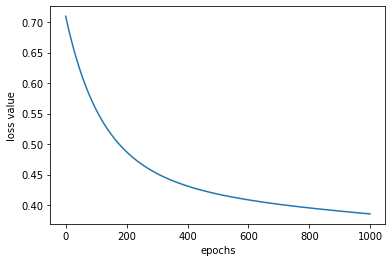

In [6]:
plt.plot(loss_val)
plt.xlabel("epochs")
plt.ylabel("loss value")

### look at pred. value distributions

In [7]:
#ff_model = feed_forward_model()
with torch.no_grad():
    model = torch.load("ff_scripted.pt")
    model.eval()
    
eval_pred = model(input_data).detach().numpy()   
eval_true = truth_class.detach().numpy()




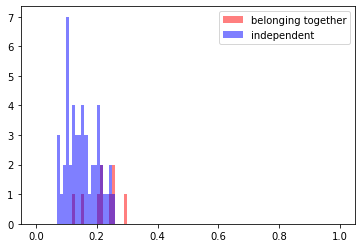

In [8]:
plt.hist(eval_pred[eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(eval_pred[eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.legend()

In [9]:
      
def run_lr(min_val,max_val,stepsize):
    #assert min_val.isdigit(), f"number is not integer, got: {type(min_val)}"
    #assert max_val.isdigit(), f"number is not integer, got: {type(max_val)}"
    #assert stepsize.isdigit(), f"number is not integer, got: {type(stepsize)}"
    n_epochs = 1000
    model = feed_forward_model(1000)
    loss_fn = nn.BCELoss()  # binary cross entropy
    loss_step_vals =[]
    for i in range(stepsize):
            lr_i = ((max_val - min_val)/stepsize)*i+min_val 
            optimizer = optim.SGD(model.parameters(), lr=lr_i)
            model.train()
            loss_val = []
            for epoch in range(n_epochs):
                y_pred = model(input_data)
                y_true = truth_class
                loss = loss_fn(y_pred,y_true)
                loss_val.append(loss.detach().item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_step_vals.append(loss_val)
    return loss_step_vals
    
    
    
    

def run_out_features(min_val,max_val,stepsize):
    n_epochs = 10000                                             ##set default n_epochs = 1000
    loss_fn = nn.BCELoss()  # binary cross entropy
    loss_step_vals =[]
    for i in range(stepsize):
            features = ((max_val - min_val)/stepsize)*i+min_val
            print("these are the features...",int(features))
            model = feed_forward_model(int(features))
            #optimizer = optim.SGD(model.parameters(), lr=9e-3)  ##set default lr
            optimizer = optim.SGD(model.parameters(), lr=5e-2)
            model.train()
            loss_val = []
            for epoch in range(n_epochs):
                y_pred = model(input_data)
                y_true = truth_class
                loss = loss_fn(y_pred,y_true)
                loss_val.append(loss.detach().item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_step_vals.append(loss_val)
    return loss_step_vals
    
def run_model(features,learning_rate):
    n_epochs = 1000
    model = feed_forward_model(features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]



In [10]:
min_val = 1e-5
max_val = 9e-1
stepsize = 20

test = run_lr(min_val,max_val,stepsize)

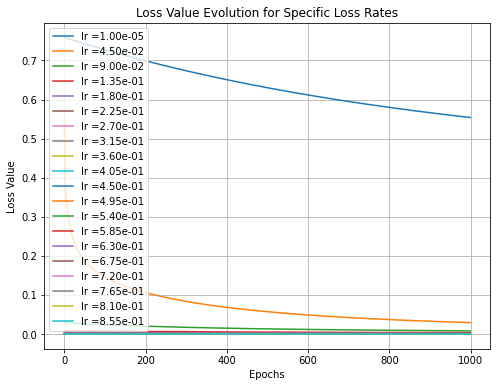

In [11]:


lable_targets = [((max_val - min_val)/stepsize)*i+min_val for i in range(stepsize)]
formatted_labels = [f'{label:.2e}' for label in lable_targets]

plt.figure(figsize=(8, 6))

for y,label in zip(test,formatted_labels):
    plt.plot(y,label="lr ="+label)
    

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper left')  # Add a legend to identify the lines
plt.title("Loss Value Evolution for Specific Loss Rates")
plt.grid(True)
plt.savefig("learning_rate_vs_loss.png")

### ok now look systematically at feature_nr evolution

In [12]:
min_val = 10
max_val = 6000
stepsize = 10
assert ((max_val-min_val) % stepsize == 0), "Wrong step size!"
test = run_out_features(min_val,max_val,stepsize)

these are the features... 10
these are the features... 609
these are the features... 1208
these are the features... 1807
these are the features... 2406
these are the features... 3005
these are the features... 3604
these are the features... 4203
these are the features... 4802
these are the features... 5401


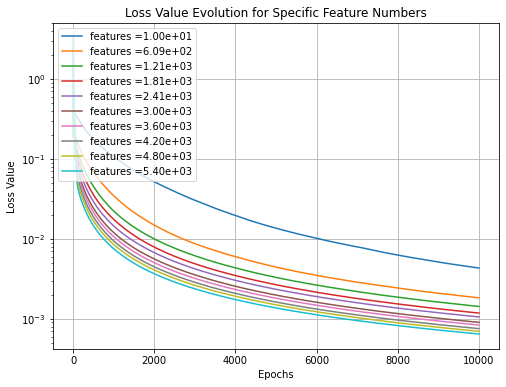

In [13]:
lable_targets = [((max_val - min_val)/stepsize)*i+min_val for i in range(stepsize)]
formatted_labels = [f'{label:.2e}' for label in lable_targets]

plt.figure(figsize=(8, 6))

for y,label in zip(test,formatted_labels):
    plt.plot(y,label="features ="+label)
    
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper left')  # Add a legend to identify the lines
plt.title("Loss Value Evolution for Specific Feature Numbers")
#plt.ylim(0, 0.2)
plt.grid(True)
plt.savefig("feature_size_vs_loss.png")

### make some plots indep/belonging together

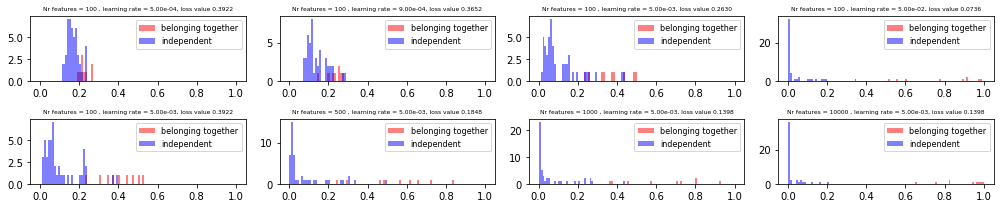

In [14]:

fig, axs = plt.subplots(2,4,figsize=(14,3))
fig.tight_layout()
##learning_rate variation
eval_pred_lr1 = run_model(100,5e-4)
eval_pred_lr2 = run_model(100,9e-4)
eval_pred_lr3 = run_model(100,5e-3)
eval_pred_lr4 = run_model(100,5e-2)
axs[0,0].hist(eval_pred_lr1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,0].hist(eval_pred_lr1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-4,eval_pred_lr1[1]),fontsize=6)
axs[0,0].legend(fontsize=8)

axs[0,1].hist(eval_pred_lr2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,1].hist(eval_pred_lr2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,9e-4,eval_pred_lr2[1]),fontsize=6)
axs[0,1].legend(fontsize=8)


axs[0,2].hist(eval_pred_lr3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,2].hist(eval_pred_lr3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-3,eval_pred_lr3[1]),fontsize=6)
axs[0,2].legend(fontsize=8)



axs[0,3].hist(eval_pred_lr4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,3].hist(eval_pred_lr4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-2,eval_pred_lr4[1]),fontsize=6)
axs[0,3].legend(fontsize=8)

## feature size variation
eval_pred_ft1 = run_model(100,5e-3)
eval_pred_ft2 = run_model(500,5e-3)
eval_pred_ft3 = run_model(1000,5e-3)
eval_pred_ft4 = run_model(10000,5e-3)

axs[1,0].hist(eval_pred_ft1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,0].hist(eval_pred_ft1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-3,eval_pred_lr1[1]),fontsize=6)
axs[1,0].legend(fontsize=8)

axs[1,1].hist(eval_pred_ft2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,1].hist(eval_pred_ft2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (500,5e-3,eval_pred_ft2[1]),fontsize=6)
axs[1,1].legend(fontsize=8)


axs[1,2].hist(eval_pred_ft3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,2].hist(eval_pred_ft3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (1000,5e-3,eval_pred_ft3[1]),fontsize=6)
axs[1,2].legend(fontsize=8)


axs[1,3].hist(eval_pred_ft4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,3].hist(eval_pred_ft4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (10000,5e-3,eval_pred_ft3[1]),fontsize=6)
axs[1,3].legend(fontsize=8)


fig.tight_layout()
plt.savefig("feature_size_and_lr_vs_loss.png")

### include now a second hidden layer (and maybe another one more...)

#### I would say to put in up to 5 hidden layers, with feature size = 256 or even a mixture

In [15]:
class hidden_layer_model(nn.Module):
        def __init__(self,nodes,hidden_nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                self.another_linear = torch.nn.Linear(nodes,hidden_nodes)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(hidden_nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.another_linear(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor

class two_hidden_layer_model(nn.Module):
        def __init__(self,nodes,hidden_nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                self.another_linear = torch.nn.Linear(nodes,hidden_nodes)
                self.another_linear_two = torch.nn.Linear(hidden_nodes,hidden_nodes)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(hidden_nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.another_linear(output_tensor)
                output_tensor = self.another_linear_two(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor
    

In [16]:
def run_hidden_model(features,learning_rate,hidden_features):
    n_epochs = 1000
    model = hidden_layer_model(features,hidden_features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]

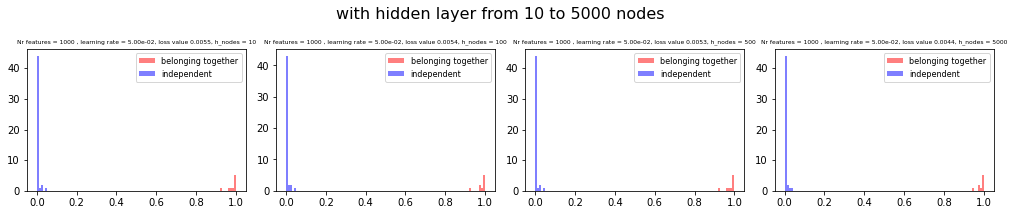

In [17]:

fig, axs = plt.subplots(1,4,figsize=(14,3))
fig.tight_layout()

##hidden layer nodes  variation
eval_pred_h1 = run_hidden_model(1000,5e-2,10)
eval_pred_h2 = run_hidden_model(1000,5e-2,100)
eval_pred_h3 = run_hidden_model(1000,5e-2,500)
eval_pred_h4 = run_hidden_model(1000,5e-2,5000)
axs[0].hist(eval_pred_h1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0].hist(eval_pred_h1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h1[1],10),fontsize=6)
axs[0].legend(fontsize=8)
axs[1].hist(eval_pred_h2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1].hist(eval_pred_h2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h2[1],100),fontsize=6)
axs[1].legend(fontsize=8)
axs[2].hist(eval_pred_h3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[2].hist(eval_pred_h3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h3[1],500),fontsize=6)
axs[2].legend(fontsize=8)
axs[3].hist(eval_pred_h4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[3].hist(eval_pred_h4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h4[1],5000),fontsize=6)
axs[3].legend(fontsize=8)
fig.suptitle('with hidden layer from 10 to 5000 nodes', fontsize=16)
fig.tight_layout()
plt.savefig("one_hidden_layer.png")





In [18]:
def run_two_hidden_model(features,learning_rate,hidden_features):
    n_epochs = 1000
    model = two_hidden_layer_model(features,hidden_features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]
    

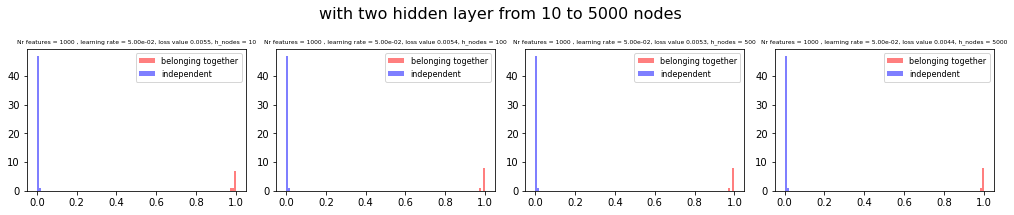

In [19]:
fig, axs = plt.subplots(1,4,figsize=(14,3))
fig.tight_layout()

##hidden layer nodes  variation
eval_pred_hh1 = run_two_hidden_model(1000,5e-2,10)
eval_pred_hh2 = run_two_hidden_model(1000,5e-2,100)
eval_pred_hh3 = run_two_hidden_model(1000,5e-2,500)
eval_pred_hh4 = run_two_hidden_model(1000,5e-2,5000)
axs[0].hist(eval_pred_hh1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0].hist(eval_pred_hh1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h1[1],10),fontsize=6)
axs[0].legend(fontsize=8)
axs[1].hist(eval_pred_hh2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1].hist(eval_pred_hh2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h2[1],100),fontsize=6)
axs[1].legend(fontsize=8)
axs[2].hist(eval_pred_hh3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[2].hist(eval_pred_hh3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h3[1],500),fontsize=6)
axs[2].legend(fontsize=8)
axs[3].hist(eval_pred_hh4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[3].hist(eval_pred_hh4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h4[1],5000),fontsize=6)
axs[3].legend(fontsize=8)
fig.suptitle('with two hidden layer from 10 to 5000 nodes', fontsize=16)
fig.tight_layout()
plt.savefig("two_hidden_layers.png")

## spectra plotting

30
1.128016
1.386997
2.209619
2.173569
2.029792
0.756178
2.1872
2.168095
2.12424
2.165567
2.083081
2.17151
2.145626
2.124236
2.11219
1.763002
1.702479
1.654359
2.126192
0.887473
2.10968
1.4561860000000002
2.154496
1.302665
2.104961
2.141112
2.075262
2.107771
2.133439
0.432454
(57,)
0.0113851605
[2.67368625e-03 1.13851605e-02 9.79196368e-09 9.87139761e-01
 1.67997598e-08 6.15284250e-07 9.74318683e-01 2.35029529e-09
 2.45554838e-04 9.48787786e-08 1.41475312e-02 3.81010103e-08
 3.02055984e-11 1.89020458e-04 1.09636128e-12 9.99998689e-01
 1.48664043e-07 9.53755546e-08 3.04110070e-10 6.49139052e-03
 1.71417755e-10 9.96235669e-01 1.96742409e-08 2.13499955e-08
 3.77096443e-09 1.84755073e-08 2.28638761e-03 2.56813280e-07
 2.32641604e-02 9.77565885e-01 9.96056318e-01 6.47826309e-05
 1.58903495e-05 1.05244137e-04 3.29084578e-04 1.92234015e-08
 9.99894023e-01 8.91271885e-03 6.57801911e-06 1.80773146e-04
 3.65822883e-09 1.00530329e-07 9.98980224e-01 2.25791482e-07
 6.27672719e-03 1.07207441e-07 1.

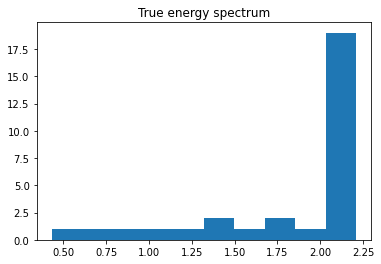

In [20]:
energy_spec = []
unique_ind = np.unique(data[:,0])
print(unique_ind.shape[0])
for i in range(unique_ind.shape[0]):
    ene = np.sum(data[data[:,0] == i,1])
    print (ene)
    energy_spec.append(ene)

plt.hist(energy_spec)
plt.title("True energy spectrum")

print(eval_pred_h4[0].shape)
print(eval_pred_h4[0][1])

print(eval_pred_h4[0])

[[ 0.          1.128016    0.913283   -2.69977     0.27121927]
 [ 1.          0.952915    0.519144    0.878809    0.95261156]
 [ 1.          0.434082    0.56767    -2.311936    0.93668561]
 [ 2.          2.209619    1.105468    2.333682    0.52416023]
 [ 3.          1.71197     1.189179    1.119164    0.78435412]
 [ 3.          0.461599    0.777167   -0.144536    0.75403444]
 [ 4.          2.029792    1.287946    1.30295     0.        ]
 [ 5.          0.756178    1.33176    -2.309371    0.68407621]
 [ 6.          2.1872      0.476108    2.85122     0.8842718 ]
 [ 7.          1.921325    1.287711   -2.407052    1.        ]
 [ 7.          0.24677     0.972258    1.512456    0.95922116]
 [ 8.          2.12424     1.190137    0.532672    0.63181968]
 [ 9.          2.165567    0.780356    1.333373    0.52338727]
 [10.          1.927867    0.979187   -1.390222    0.83159162]
 [10.          0.155214    1.058012   -2.217043    0.81032574]
 [11.          2.17151     0.581699   -0.050691    0.75

Text(0.5, 1.0, 'Reconstructed energy spectrum')

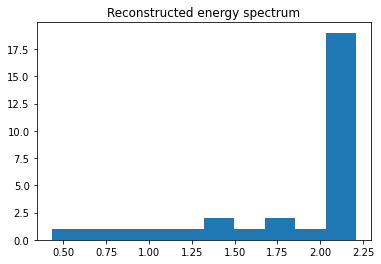

In [21]:
import networkx as nx
print(data)
ene_list = []
idx = 0
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    evt = data[mask]
    print(evt)
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    ##pair indices which belong together...
    pred_comb = []
    for m in range(evt.shape[0]):
        pred_comb.append((m,m))
    for j in range (len(pair_indices)):
        if eval_pred_h4[0][idx+j] > 0.5:
            pred_comb.append(pair_indices[j])
    G = nx.Graph()
    G.add_edges_from(pred_comb)
    connected_components = list(nx.connected_components(G))
    print("Connected components:", connected_components)
    print(type(connected_components))
    for k in range(len(connected_components)):
        print("this is type of k:")
        columns_to_sum = evt[list(connected_components[k]),1]
        ene = np.sum(columns_to_sum)
        ene_list.append(ene)
        print(ene)
        print(type(connected_components[k]))
    idx += len(pair_indices)


plt.hist(ene_list)
plt.title("Reconstructed energy spectrum")
    # for i, (idx1, idx2) in enumerate(pair_indices):
    #     l = []
    #     l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
    #     ll.append(l)
    #     if (evt[idx1,0] == evt[idx2,0]):
    #         true_vals.append(1)
    #     else:
    #         true_vals.append(0)